In [1]:
#Nama : Farah Qotrunnada
#Email : farah.nada14@gmail.com

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta

In [3]:
# Membuat tabel (jika belum ada)
import sqlite3
namadb='farahnada14App.db'
connection = sqlite3.connect(namadb)
create_table = '''CREATE TABLE IF NOT EXISTS tweets (
                            [Tweet ID] INTEGER PRIMARY KEY AUTOINCREMENT,
                            User TEXT NOT NULL,
                            [Tanggal Tweet] TEXT NOT NULL,
                            Tweet TEXT NOT NULL,
                            Sentiment INTEGER );'''

cursor = connection.cursor()
cursor.execute(create_table)
connection.commit()
cursor.close()
connection.close()

In [4]:
# Twitter developer authentifikasi
import tweepy
consumer_key = "r8NHXq0wMic2RkIEPF2Dj2yTY"
consumer_secret = "XjLNSI8F9MFEsmufryVStV7E7hX66ailXzgloS1bUqy6psV27r"
access_token = "2595717204-jimLBp6UjMtpAX1d7wraJ7gHFkrawv68PAgI5Cp"
access_token_secret = "xwAojoW2FJIQtUW7IkbWH5OXUscF860aUO6CZOHRDaPI7"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [5]:
def UpdateData():
    
    # Pencarian keyword pada tweet sejak 1 hari lalu
    search_words = "vaksin covid"
    new_search = search_words + " -filter:retweets"
    date_since=(datetime.now()-timedelta(days=1)).strftime('%Y-%m-%d')
    tweets = tweepy.Cursor(api.search,tweet_mode='extended',
            q=new_search,
            lang="id",
            since=date_since).items(100)
    
    # Memasukkan hasil pencarian pada list
    items = []
    for tweet in tweets:
        item = []
        item.append (tweet.id)
        item.append (tweet.user.screen_name)
        item.append ((tweet.created_at)+timedelta(hours=7))
        item.append (tweet.full_text)
        items.append(item)
    
    # Insert list pada database
    connection = sqlite3.connect(namadb)
    query = 'INSERT OR IGNORE INTO tweets ([Tweet ID], User, [Tanggal Tweet], Tweet) VALUES(?,?,?,?);'
    cursor = connection.cursor()
    cursor.executemany(query, items)
    connection.commit()
    cursor.close()
    connection.close()
    
    print('Database sudah di update ya!')

In [6]:
def UpdateSentiment():
    
    # Mengambil tweet yang belum memiliki sentiment dari database
    connection = sqlite3.connect(namadb)
    cursor = connection.cursor()
    cursor.execute('SELECT Tweet FROM tweets WHERE Sentiment IS NULL')
    hasil1 =  cursor.fetchall()
    cursor.close()
    
    # Analisis sentimen dan update pada database
    pos_list= open("./kata_positif.txt","r")
    pos_kata = pos_list.readlines()
    neg_list= open("./kata_negatif.txt","r")
    neg_kata = neg_list.readlines()
    
    for item in hasil1:
        count_p = 0
        count_n = 0
        
        kalimatt=re.sub("(\d+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item[0]).lower().split()
        listStopword = ['yang','akan','di','dan','yg','atau','dari']
        removed = []
        for t in kalimatt:
            if t not in listStopword:
                removed.append(t)
        kal=' '.join(removed)
        
        for kata_pos in pos_kata:
            if kata_pos.strip() in kal:
                count_p +=1
        for kata_neg in neg_kata:
            if kata_neg.strip() in kal:
                count_n +=1
                
        val=(count_p-count_n,item[0])
        connection = sqlite3.connect(namadb)
        cursor = connection.cursor()
        cursor.execute('UPDATE tweets SET Sentiment=? WHERE Tweet=?',val)
        connection.commit()
        cursor.close()
        connection.close()     
    
    print('Nilai sentiment sudah di update:)')

In [7]:
def LihatData():
    
    # User memasukan input sampai sesuai format
    cek=0
    while cek==0:
        awal=input('Masukkan tanggal awal ya (contoh: 2020-02-16) :')
        akhir=input('Hingga tanggal berapa nih? *tanggal ini juga masuk ya (contoh: 2020-04-30) :')
        try:
            datetime.strptime(awal, '%Y-%m-%d')
            datetime.strptime(akhir, '%Y-%m-%d')
            cek=1
        except ValueError:
            print("Yah, penulisan salah. Tulis dengan format YYYY-MM-DD ya")
        if cek==1:
            if awal>=akhir:
                cek=0
                print('Tanggal akhir harus lebih besar dari tanggal awal ya')
            

    # Mengambil data dari database
    connection = sqlite3.connect(namadb)
    cursor = connection.cursor()
    cursor.execute('SELECT User, [Tanggal Tweet], Tweet FROM tweets;')
    hasil =  cursor.fetchall()
    cursor.close()
    connection.close()  
    
    # Menampilkan data
    pd.set_option('max_colwidth', None)
    pd.set_option('display.max_rows', None)
    
    df=pd.DataFrame(hasil, columns=['User','Tanggal Tweet','Tweet'])
    akhirr=( datetime.strptime(akhir,'%Y-%m-%d')+timedelta(days=1) ).strftime('%Y-%m-%d')
    da=df.loc[df['Tanggal Tweet']>awal]
    dak=da.loc[da['Tanggal Tweet']<akhirr].reset_index(drop=True)
    
    # Jam tweet tidak ditampilkan
    dak.loc[:,'Tanggal Tweet']=[x[:10] for x in dak.loc[:,'Tanggal Tweet']]
 
    print(dak)
    

In [8]:
def Visualisasi():
    # User memasukan input sampai sesuai format (preference pribadi:mencoba tgl akhir tidak dimasukkan)
    cek=0
    while cek==0:
        awal=input('Masukkan tanggal awal ya (contoh: 2020-02-16) :')
        akhir=input('Hingga tanggal berapa nih? *tanggal ini tidak termasuk ya (contoh: 2020-04-30) :')
        try:
            datetime.strptime(awal, '%Y-%m-%d')
            datetime.strptime(akhir, '%Y-%m-%d')
            cek=1
        except ValueError:
            print("Yah, penulisan salah. Tulis dengan format YYYY-MM-DD ya")
        if cek==1:
            if awal>=akhir:
                cek=0
                print('Tanggal akhir harus lebih besar dari tanggal awal ya')
            
    # Mengambil kolom sentiment dari database
    connection = sqlite3.connect(namadb)
    cursor = connection.cursor()
    val=(awal,akhir)
    cursor.execute('SELECT Sentiment FROM tweets WHERE [Tanggal Tweet]>? AND [Tanggal Tweet]<?;',val)
    hasil3 =  cursor.fetchall()
    cursor.close()
    connection.close()
    
    # Menampilkan hasil analisis sentiment
    print ("Nilai rata-rata: "+str(np.mean(hasil3)))
    print ("Nilai median: "+str(np.median(hasil3)))
    print ("Standar deviasi: "+str(np.std(hasil3)))
    plt.style.use('Solarize_Light2')
    labels, counts = np.unique(hasil3, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title('Histogram Nilai Sentiment Twitter')
    plt.show()   

Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :1
Database sudah di update ya!
Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :3
Masukkan tanggal awal ya (contoh: 2020-02-16) :2020-08-13
Hingga tanggal berapa nih? *tanggal ini juga masuk ya (contoh: 2020-04-30) :2021-1-1
                User Tanggal Tweet  \
0     thearcher_ayuk    2020-08-13   
1       hariankompas    2020-08-13   
2        boyandronna    2020-08-13   
3       hariankompas    2020-08-13   
4        riyantifame    2020-08-13   
5     newsmerahputih    2020-08-13   
6          YRuhiyat3    2020-08-13   
7           hmetromy    2020-08-13   
8          BryokAceh    2020-08-13   
9         AnisHudaya    2020-08-13   
10   rep

Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :3
Masukkan tanggal awal ya (contoh: 2020-02-16) :2020-08-14
Hingga tanggal berapa nih? *tanggal ini juga masuk ya (contoh: 2020-04-30) :2020-08-15
               User Tanggal Tweet  \
0    _TitipanILahi_    2020-08-14   
1         IvoneHall    2020-08-14   
2         LeeJoJoo2    2020-08-14   
3          IDCorner    2020-08-14   
4         Pkb_Blora    2020-08-14   
5          iDParera    2020-08-14   
6       suaradotcom    2020-08-14   
7     KompasEkonomi    2020-08-14   
8         kompascom    2020-08-14   
9         jurnascom    2020-08-14   
10     husada_menik    2020-08-14   
11    infokabinetID    2020-08-14   
12         VIVAcoid    2020-08-14   
13     beritaIDN_id    2020-08-14   
14     kabarpolitik    2020-08-14   
15         kabarpol    2020-08-14   
16   mediaindonesia    20

Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :4
Masukkan tanggal awal ya (contoh: 2020-02-16) :2020-08-12
Hingga tanggal berapa nih? *tanggal ini tidak termasuk ya (contoh: 2020-04-30) :2020-08-15
Nilai rata-rata: -0.45
Nilai median: 0.0
Standar deviasi: 2.71062723368596


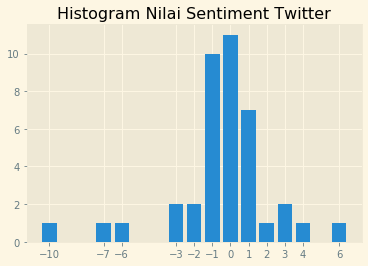

Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :4
Masukkan tanggal awal ya (contoh: 2020-02-16) :2000-1-1
Hingga tanggal berapa nih? *tanggal ini tidak termasuk ya (contoh: 2020-04-30) :2021-1-1
Coba update nilai sentiment terlebih dahulu ya!
Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :2
Nilai sentiment sudah di update:)
Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :4
Masukkan tanggal awal ya (contoh: 2020-02-16) :2000-1-1
Hingga tanggal berapa nih? *tanggal ini tidak termasuk ya (contoh: 2020-04-30) :2021-1-1
Nilai rata-rata: 0.079831

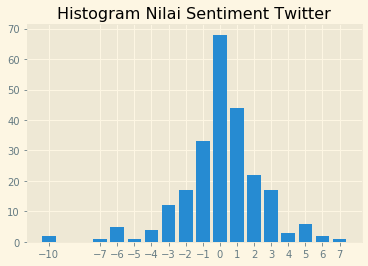

Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :5


In [9]:
# Play with user
cek=0
while cek==0:
    ow=input('''Hai! Apa yang ingin kamu lakukan?
        1. Update Data
        2. Update Nilai Sentiment
        3. Lihat data
        4. Visualisasi
        5. Keluar
        (Masukkan nomornya saja)
Input Anda :''')
    if ow=='1':
        UpdateData()
    elif ow=='2':
        UpdateSentiment()
    elif ow=='3':
        LihatData()
    elif ow=='4':
        try:
            Visualisasi()
        except:
            print('Coba update nilai sentiment terlebih dahulu ya!')
    elif ow=='5':
        cek=1
    else:
        print('Masukkan nomor yang ada di menu ya')